## Regression with Python

TOC

- test assumption of regression
- perform forward and backward selection
- perform PCA and visualize the results
- feature selection with lasso regression
- detect outliers

## Load libraries

In [165]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) 
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set(rc={'figure.figsize':(12,6)})

from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.tsa.api as smt

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

## Load data

In [102]:
diabetes = datasets.load_diabetes()

df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
df['target'] = diabetes.target
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038,0.051,0.062,0.022,-0.044,-0.035,-0.043,-0.003,0.020,-0.018,151.000
1,-0.002,-0.045,-0.051,-0.026,-0.008,-0.019,0.074,-0.039,-0.068,-0.092,75.000
2,0.085,0.051,0.044,-0.006,-0.046,-0.034,-0.032,-0.003,0.003,-0.026,141.000
3,-0.089,-0.045,-0.012,-0.037,0.012,0.025,-0.036,0.034,0.023,-0.009,206.000
4,0.005,-0.045,-0.036,0.022,0.004,0.016,0.008,-0.003,-0.032,-0.047,135.000


## Test assumption of regression

code source: https://towardsdatascience.com/verifying-the-assumptions-of-linear-regression-in-python-and-r-f4cd2907d4c0

In [133]:
X = df.drop('target', axis=1)
y = df['target']

X_constant = sm.add_constant(X)
lin_reg = sm.OLS(y, X_constant).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     46.27
Date:                Thu, 24 Nov 2022   Prob (F-statistic):           3.83e-62
Time:                        11:13:44   Log-Likelihood:                -2386.0
No. Observations:                 442   AIC:                             4794.
Df Residuals:                     431   BIC:                             4839.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        152.1335      2.576     59.061      0.000     147.071     157.196
age          -10.0122     59.749     -0.168      0.867    -127.448     107.424
sex         -239.8191     61.222     -3.917      0.000    -360.151    -119.488
bmi          519.8398     66.534      7.813      0.000     389.069     650.610
bp           324.3904     65.422      4.958      0.000     195.805     452.976
s1          -792.1842    416.684     -1.901      0.058   -1611.169      26.801
s2           476.7458    339.035      1.406      0.160    -189.621    1143.113
s3           101.0446    212.533      0.475      0.635    -316.685     518.774
s4           177.0642    161.476      1.097      0.273    -140.313     494.442
s5           751.2793    171.902      4.370      0.000     413.409    1089.150
s6            67.6254     65.984      1.025      0.306     -62.065     197.316
==============================================================================
Omnibus:                        1.506   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.471   Jarque-Bera (JB):                1.404
Skew:                           0.017   Prob(JB):                        0.496
Kurtosis:                       2.726   Cond. No.                         227.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### linearity

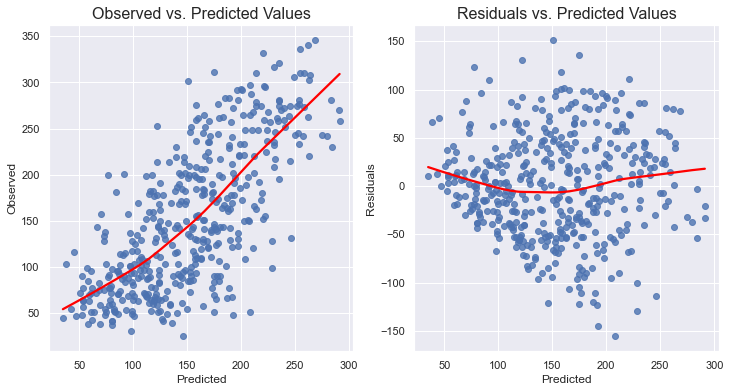

In [154]:
pred = lin_reg.predict()
resids = lin_reg.resid

fig, ax = plt.subplots(1, 2)

sns.regplot(x=pred, y=y, lowess=True, ax=ax[0], line_kws={"color": "red"})
ax[0].set_title("Observed vs. Predicted Values", fontsize=16)
ax[0].set(xlabel="Predicted", ylabel="Observed")

sns.regplot(x=pred, y=resids, lowess=True, ax=ax[1], line_kws={"color": "red"})
ax[1].set_title("Residuals vs. Predicted Values", fontsize=16)
ax[1].set(xlabel="Predicted", ylabel="Residuals");

- plot on the left : desired outcome is points are symmetrically distributed around the diagonal line 
- plot on the right : desired outcome is points are symmetrically distributed around the horizontal line

### Normality of residuals

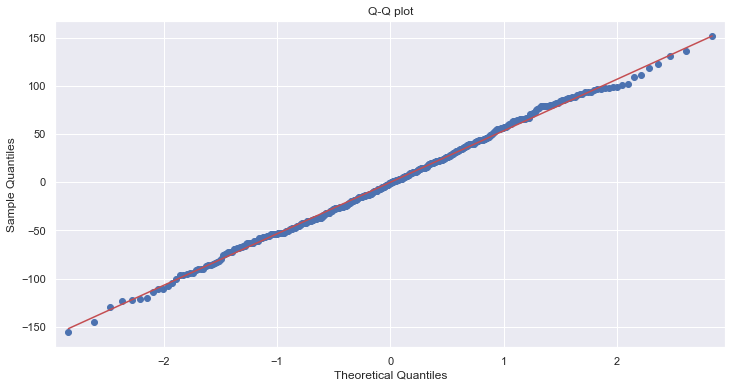

In [157]:
sm.ProbPlot(lin_reg.resid).qqplot(line='s');
plt.title('Q-Q plot');

### Equal variance

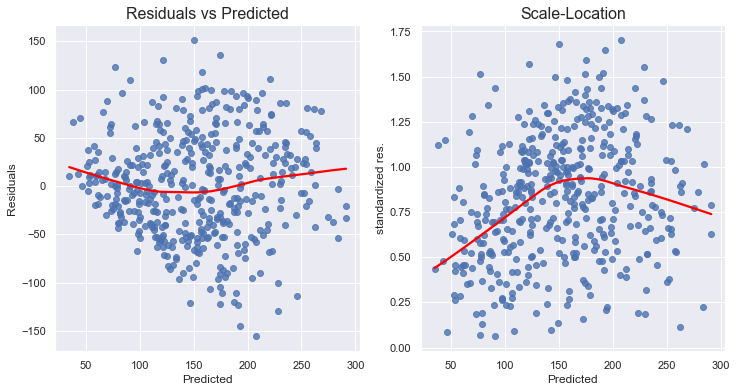

In [152]:
pred = lin_reg.predict()
resids = lin_reg.resid
resids_standardized = lin_reg.get_influence().resid_studentized_internal

fig, ax = plt.subplots(1, 2)

sns.regplot(x=pred, y=resids, lowess=True, ax=ax[0], line_kws={"color": "red"})
ax[0].set_title("Residuals vs Predicted", fontsize=16)
ax[0].set(xlabel="Predicted", ylabel="Residuals")

sns.regplot(
    x=pred,
    y=np.sqrt(np.abs(resids_standardized)),
    lowess=True,
    ax=ax[1],
    line_kws={"color": "red"},
)
ax[1].set_title("Scale-Location", fontsize=16)
ax[1].set(xlabel="Predicted", ylabel="standardized res.")


### No multicollinearity

In [155]:
vif = [variance_inflation_factor(X_constant.values, i) for i in range(X_constant.shape[1])]

pd.DataFrame({"vif": vif[1:]}, index=X.columns)

,vif
age,1.217
sex,1.278
bmi,1.509
bp,1.459
s1,59.204
s2,39.194
s3,15.402
s4,8.891
s5,10.076
s6,1.485


- A rule of thumb for removal could be VIF larger than 10 (5 is also common)
- s1, s2, s3 and s5 have possible multicollinearity

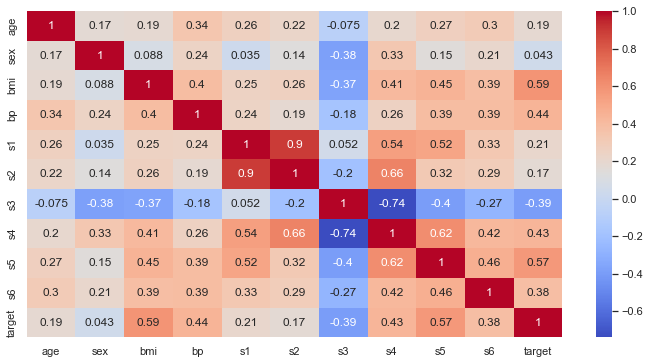

In [163]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm');

### No autocorrelation

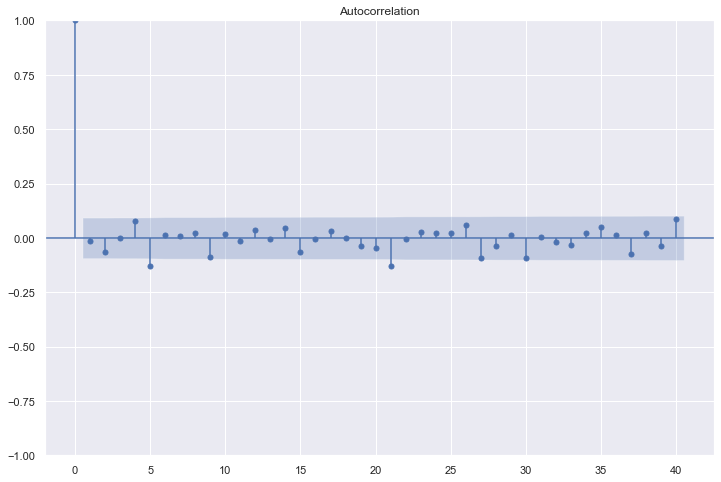

In [143]:
acf = smt.graphics.plot_acf(lin_reg.resid, lags=40 , alpha=0.05)
acf.show()

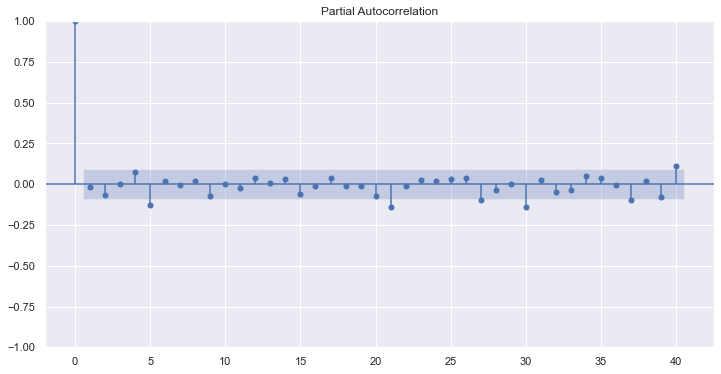

In [161]:
sm.graphics.tsa.plot_pacf(lin_reg.resid, lags=40)

## variable selection

In [228]:
# clean dataset
# https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard

# load train and test data
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

train_ID = train["Id"]
test_ID = test["Id"]

# Deleting outliers
train = train.drop(
    train[(train["GrLivArea"] > 4000) & (train["SalePrice"] < 300000)].index
)
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(["SalePrice"], axis=1, inplace=True)

# missing data

all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median())
)
for col in ("GarageType", "GarageFinish", "GarageQual", "GarageCond"):
    all_data[col] = all_data[col].fillna("None")
for col in ("GarageYrBlt", "GarageArea", "GarageCars"):
    all_data[col] = all_data[col].fillna(0)
for col in (
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "BsmtFullBath",
    "BsmtHalfBath",
):
    all_data[col] = all_data[col].fillna(0)
for col in ("BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"):
    all_data[col] = all_data[col].fillna("None")
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data["MSZoning"] = all_data["MSZoning"].fillna(all_data["MSZoning"].mode()[0])
all_data = all_data.drop(["Utilities"], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data["Electrical"] = all_data["Electrical"].fillna(all_data["Electrical"].mode()[0])
all_data["KitchenQual"] = all_data["KitchenQual"].fillna(
    all_data["KitchenQual"].mode()[0]
)
all_data["Exterior1st"] = all_data["Exterior1st"].fillna(
    all_data["Exterior1st"].mode()[0]
)
all_data["Exterior2nd"] = all_data["Exterior2nd"].fillna(
    all_data["Exterior2nd"].mode()[0]
)
all_data["SaleType"] = all_data["SaleType"].fillna(all_data["SaleType"].mode()[0])
all_data["MSSubClass"] = all_data["MSSubClass"].fillna("None")
all_data["MSSubClass"] = all_data["MSSubClass"].apply(str)
all_data["OverallCond"] = all_data["OverallCond"].astype(str)
all_data["YrSold"] = all_data["YrSold"].astype(str)
all_data["MoSold"] = all_data["MoSold"].astype(str)

# label encode
cols = (
    "FireplaceQu",
    "BsmtQual",
    "BsmtCond",
    "GarageQual",
    "GarageCond",
    "ExterQual",
    "ExterCond",
    "HeatingQC",
    "PoolQC",
    "KitchenQual",
    "BsmtFinType1",
    "BsmtFinType2",
    "Functional",
    "Fence",
    "BsmtExposure",
    "GarageFinish",
    "LandSlope",
    "LotShape",
    "PavedDrive",
    "Street",
    "Alley",
    "CentralAir",
    "MSSubClass",
    "OverallCond",
    "YrSold",
    "MoSold",
)
for c in cols:
    lbl = LabelEncoder()
    lbl.fit(list(all_data[c].values))
    all_data[c] = lbl.transform(list(all_data[c].values))

# new features
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

# dealing with skewness
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness = skewness[abs(skewness) > 0.75]
from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

# dummy variables
all_data = pd.get_dummies(all_data)
print(all_data.shape)

# new train and test
train = all_data[:ntrain]
test = all_data[ntrain:]

(2917, 221)


In [172]:
def stepwise_selection(X, y, initial_list=[], threshold_in=0.01, threshold_out = 0.05, verbose=True):
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

result = stepwise_selection(train, y_train)
# original features count
print('original features count:')
print(len(train.columns))
# after stepwise regression
print('after stepwise regression:')
print(len(result))
print('resulting features:')
print(result)

resulting features:
['TotalSF', 'OverallQual', 'YearBuilt', 'LotArea', 'OverallCond', 'KitchenQual', 'BsmtUnfSF', 'GarageCars', 'Neighborhood_Crawfor', 'MSZoning_C (all)', 'GrLivArea', 'BsmtQual', 'BsmtFinSF1', 'SaleCondition_Abnorml', 'Functional', 'ExterQual', 'Condition1_Norm', 'HeatingQC', 'SaleType_New', 'Neighborhood_BrkSide', 'Exterior1st_BrkFace', 'Neighborhood_StoneBr', 'MSZoning_RM', 'YearRemodAdd', 'Fireplaces', 'Neighborhood_NoRidge', 'Heating_Grav', 'RoofMatl_WdShngl', 'Neighborhood_Somerst', 'Neighborhood_NridgHt', 'BsmtFullBath', 'KitchenAbvGr', 'WoodDeckSF', 'ScreenPorch', 'Exterior1st_BrkComm', 'SaleType_ConLD', 'Condition2_PosA', 'PoolArea', 'Foundation_Stone']
original features count:
221
after stepwise regression:
39


## PCA

In [180]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
pca.fit(train)
pca_train = pca.transform(train)
print('train shape after pca:')
print(pca_train.shape)

train shape after pca:
(1458, 21)


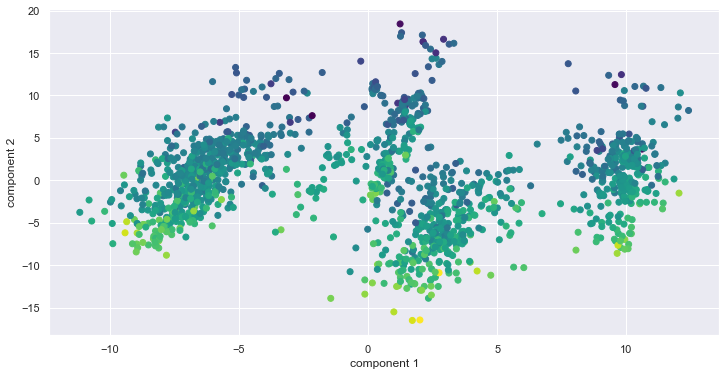

In [181]:
plt.scatter(pca_train[:, 0], pca_train[:, 1], c=y_train, cmap='viridis')
plt.xlabel('component 1')
plt.ylabel('component 2');

## Lasso regression

In [187]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

sel_ = SelectFromModel(Lasso(alpha=0.005, random_state=0))
sel_.fit(train, y_train)
sel_.get_support()
selected_feat = train.columns[(sel_.get_support())]
print('total features: {}'.format((train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(sel_.estimator_.coef_ == 0)))


total features: 221
selected features: 35
features with coefficients shrank to zero: 186


## outlier detection

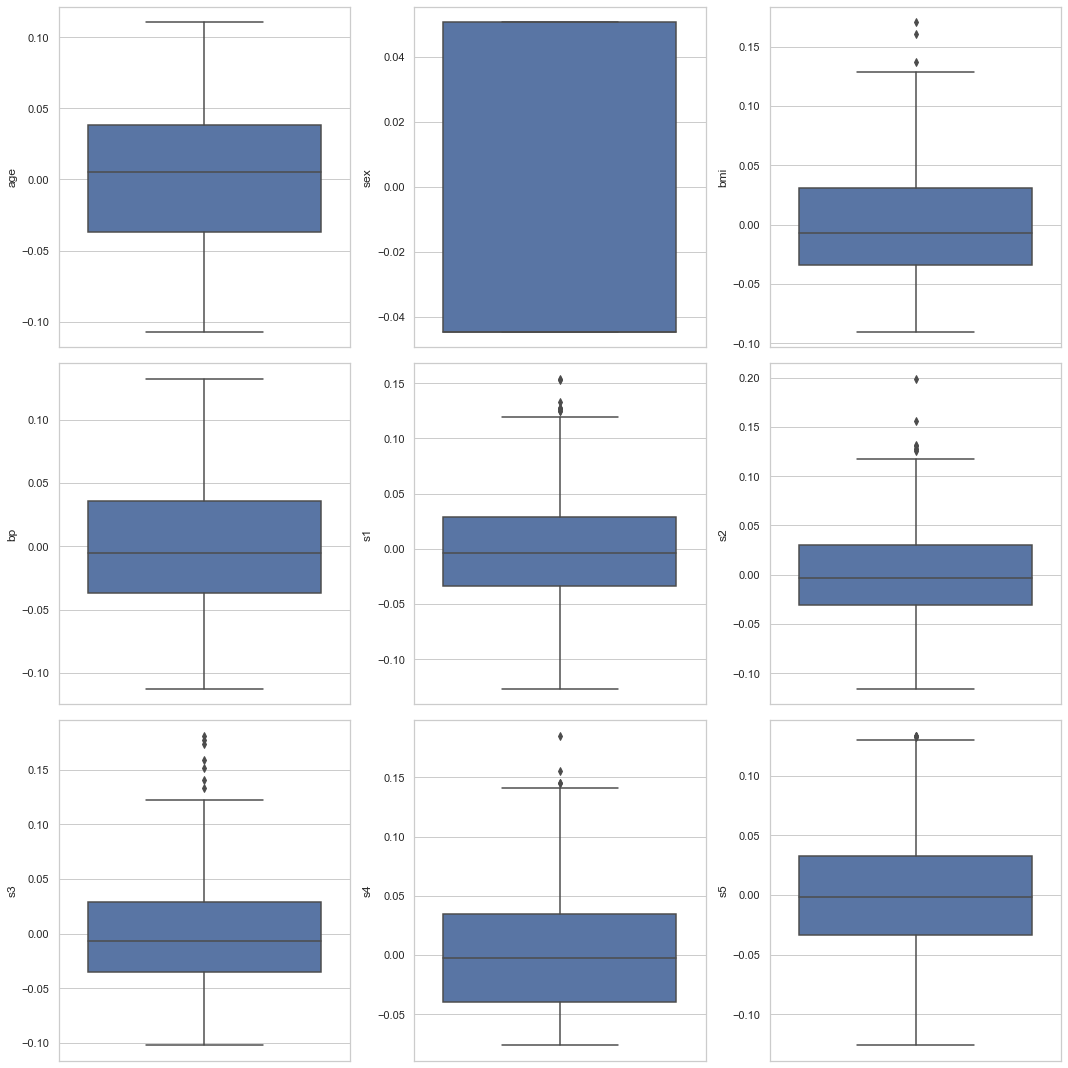

In [202]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
for i, ax in enumerate(axes.flatten()):
    sns.boxplot(y=df[df.columns[i]], ax=ax)
plt.tight_layout()

In [210]:
from scipy import stats

z = np.abs(stats.zscore(df))
threshold = 3
df_o = df[(z < 3).all(axis=1)]
print('shape of original dataset:')
print(df.shape)
print('shape of dataset after removing outliers:')
print(df_o.shape)

shape of original dataset:
(442, 11)
shape of dataset after removing outliers:
(430, 11)


In [225]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples=100, random_state=0)
clf.fit(df)
y_pred = clf.predict(df)
df_o = df[y_pred == 1]
print('shape of original dataset:')
print(df.shape)
print('shape of dataset after removing outliers:')
print(df_o.shape)

shape of original dataset:
(442, 11)
shape of dataset after removing outliers:
(340, 11)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a605a3e6-1564-47b2-94e7-842290ba7692' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>